In [1]:
import os
import os.path as op
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pathlib import Path
from scipy.stats import ttest_1samp

In [2]:
accuracy = pd.read_csv('../data/accuracy.csv')

In [16]:
root = Path('../data/bids/derivatives/decoding/')
df = pd.DataFrame()
for file in root.rglob("*/*"):
    if 'target' in str(file):
        continue
    cond = re.findall('wavelet_(\d{1,2})', file.name)[0]
    sub = re.findall('sub-(\d{1,2})', file.name)[0]
    d = np.load(file)
    d = d[416:] # Take only accuracies after tone onset, there are 0.6 msec per overlapping window
    data_dict = {
                 'cond': [cond]*501,
                 'sub': [sub]*501,
                 'accuracies': d,
                }
    sub_df = pd.DataFrame.from_dict(data_dict)
    df = pd.concat([df, sub_df], ignore_index = False)
df

,cond,sub,accuracies
0,31,7,0.500864
1,31,7,0.503012
2,31,7,0.502804
3,31,7,0.504215
4,31,7,0.507577
...,...,...,...
496,32,29,0.495005
497,32,29,0.492443
498,32,29,0.491275
499,32,29,0.491018


In [17]:
# df['target'] = df.cond.replace({'11': '1', '12':  '0', '13': '0', '21': '0', '22': '1', '23': '0', '31': '0', '32': '0', '33': '1'})
df['target'] = df.cond.replace({'11': 1, '12': 0, '13': 0, '21': 0, '22': 1, '23': 0, '31': 0, '32': 0, '33': 1})

In [18]:
df

,cond,sub,accuracies,target
0,31,7,0.500864,0
1,31,7,0.503012,0
2,31,7,0.502804,0
3,31,7,0.504215,0
4,31,7,0.507577,0
...,...,...,...,...
496,32,29,0.495005,0
497,32,29,0.492443,0
498,32,29,0.491275,0
499,32,29,0.491018,0


In [19]:
decoding_by_target = df.groupby(['sub', 'target'])['accuracies'].mean()
decoding_by_target = pd.DataFrame(decoding_by_target).reset_index()

<AxesSubplot:xlabel='target', ylabel='accuracies'>

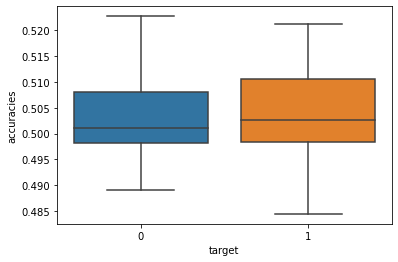

In [20]:
sns.boxplot(data = decoding_by_target, x = 'target', y = 'accuracies')

### Plot accuracies by block and target freq

In [21]:
accuracy

,Unnamed: 0,sub_num,block_num,target,n_target_plays,n_targets,response,accuracy,block number
0,0,30,3,200,4.0,14,14,1.000000,3
1,42,30,3,200,2.0,11,10,0.909091,3
2,78,30,3,130,3.0,9,9,1.000000,3
3,114,30,3,280,2.0,12,13,0.916667,3
4,156,30,3,280,3.0,11,11,1.000000,3
...,...,...,...,...,...,...,...,...,...
6465,510,5,4,130,NaN,9,9,1.000000,4
6466,546,5,4,200,NaN,9,9,1.000000,4
6467,576,5,4,280,NaN,11,12,0.909091,4
6468,606,5,4,200,NaN,12,14,0.833333,4


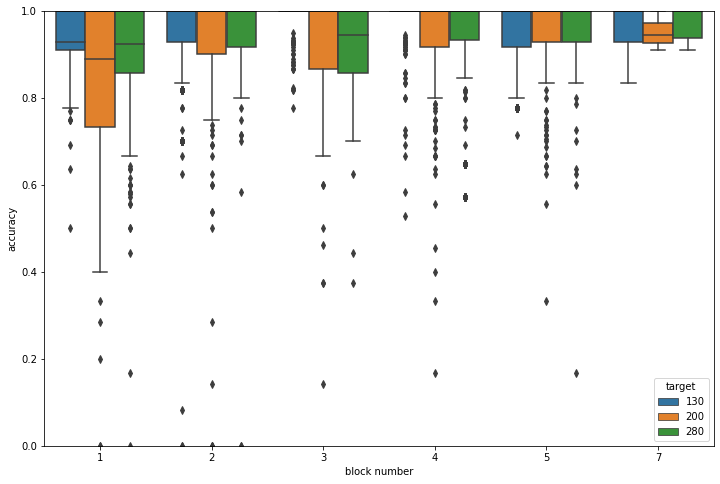

In [22]:
# Rename variables
accuracy['block number'] = accuracy['block_num']

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x = "block number", y = "accuracy", hue = "target", data = accuracy)
ax.set_ylim(0, 1)
fig = ax.get_figure()
fig.savefig('../figs/behavioral.png', dpi = 600)

### Scatterplot of task accuracy and decoding accuracy

In [27]:
decoding_by_sub = df.groupby(['sub'])['accuracies'].mean()
decoding_by_sub = pd.DataFrame(decoding_by_sub).reset_index()
decoding_by_sub['sub'] = decoding_by_sub['sub'].astype(int)
decoding_by_sub = decoding_by_sub.sort_values('sub').reset_index(drop = True)
decoding_by_sub

,sub,accuracies
0,3,0.510869
1,4,0.509488
2,5,0.499418
3,6,0.511593
4,7,0.504924
5,8,0.498252
6,9,0.502726
7,10,0.505418
8,11,0.503403
9,12,0.499606


In [24]:
accuracy_by_sub = accuracy.groupby(['sub_num'])['accuracy'].mean()
accuracy_by_sub = pd.DataFrame(accuracy_by_sub).reset_index()
accuracy_by_sub = accuracy_by_sub[~accuracy_by_sub['sub_num'].isin([1, 2, 17, 30, 31])] # drop subs
accuracy_by_sub = accuracy_by_sub.reset_index(drop = True)
accuracy_by_sub

,sub_num,accuracy
0,3,0.785415
1,4,0.958154
2,5,0.919971
3,6,0.921653
4,7,0.911613
5,8,0.989489
6,9,0.912759
7,10,0.965335
8,11,0.963677
9,12,0.973498


<AxesSubplot:xlabel='accuracy', ylabel='decoding'>

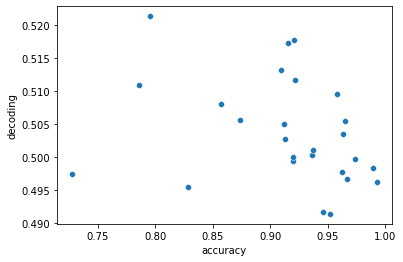

In [10]:
accuracy_by_sub['decoding'] = decoding_by_sub.accuracies
accuracy_by_sub
sns.scatterplot(data = accuracy_by_sub, x = 'accuracy', y = 'decoding')
# sns.scatterplot(data=tips, x="total_bill", y="tip")

In [13]:
# Create linear regression object
# regr = LinearRegression()

# Train the model using the training sets
x = accuracy_by_sub.accuracy.values.reshape(-1, 1)
y = decoding_by_sub.accuracies.values
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")

# # Make predictions using the testing set
# # diabetes_y_pred = regr.predict(diabetes_X_test)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# # The mean squared error
# # print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # # The coefficient of determination: 1 is perfect prediction
# # print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# # Plot outputs
# plt.scatter(accuracy_by_sub.accuracy, decoding_by_sub.accuracies, color="black")
# plt.plot(accuracy_by_sub.accuracy, decoding_by_sub.accuracies, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

coefficient of determination: 0.08886477269589466
